Specific Task 2 (if you are interested in “Diffusion Models for Fast Detector Simulation” project):
* Use a Diffusion Network model to represent the events in task 1. Please show a side-by side comparison of the original and reconstructed events and appropriate evaluation metric of your choice that estimates the difference between the two.


In [1]:
import numpy as np
import h5py
import math
import os
import numpy as np
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn.functional as F


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## data checks out

In [10]:
# Load data from HDF5 file
data_path = "/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5"  # Replace with your own file path

with h5py.File(data_path, 'r') as f:
    print(f"Keys: {list(f.keys())}")
    X_jets = f['X_jets'][0:500]                   #To work with only a subset of all images due to computational limit
    print(f"X_jets shape: {X_jets.shape}")         # Consists of image data
    # m0 = f["m0"]
    # pt = f["pt"]
    # y = f["y"]
    # print(f"m0 shape: {m0.shape}")               # Mass 
    # print(f"pt shape: {pt.shape}")               # Transverse momentum 
    # print(f"y shape: {y.shape}")                 # Labels 

# print(X_jets.shape)

Keys: ['X_jets', 'm0', 'pt', 'y']
X_jets shape: (500, 125, 125, 3)


In [21]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image.squeeze()))


In [ ]:
num_images = 3
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 20))
for i in range(num_images):
    sample = X_jets[i]
    sample = np.transpose(sample, (2, 0, 1))  # transpose to (C, H, W) format
    sample = torch.from_numpy(sample).float().unsqueeze(0)  # convert to tensor
    show_tensor_image(sample)
    axes[i].axis('off')
    axes[i].set_title('Sample {}'.format(i+1))
plt.show()


In [ ]:
# Resizing images from (125, 125, 3) to (128, 128, 3) as when decoding we want image to be in power of 2's dimension for ConvTranspose to retrieve original image dimensions
X_jets_resized = np.zeros((X_jets.shape[0], 128, 128, 3))
for i in range(X_jets.shape[0]):
    X_jets_resized[i] = smart_resize(X_jets[i], (128, 128))

X_jets = X_jets_resized
del(X_jets_resized)

In [4]:
# Normalize the input images to have values between 0 and 1 using min-max scaling.
print("Previous min, max and mean :-")
print(np.min(X_jets))
print(np.max(X_jets))
print(np.mean(X_jets))

X_jets = (X_jets - X_jets.min()) / (X_jets.max() - X_jets.min()) 

print("\nAfter normalization min, max and mean :-")
print(np.min(X_jets))
print(np.max(X_jets))
print(np.mean(X_jets))

Previous min, max and mean :-
0.0
9.868629
5.2976822e-05

After normalization min, max and mean :-
0.0
1.0
5.368201e-06


In [11]:
# Normalize Track, ECAL, HCAL data using mean and standard deviation
mean_track = np.mean(X_jets[:,:,:,0])
std_track = np.std(X_jets[:,:,:,0])
normalized_track = (X_jets[:,:,:,0] - mean_track) / std_track

mean_ecal = np.mean(X_jets[:,:,:,1])
std_ecal = np.std(X_jets[:,:,:,1])
normalized_ecal = (X_jets[:,:,:,1] - mean_ecal) / std_ecal

mean_hcal = np.mean(X_jets[:,:,:,2])
std_hcal = np.std(X_jets[:,:,:,2])
normalized_hcal = (X_jets[:,:,:,2] - mean_hcal) / std_hcal


combined = normalized_track + normalized_ecal + normalized_hcal
combined = np.expand_dims(combined, axis=-1)  # Reshape to (n, 128, 128, 1)


In [12]:
combined.shape

(500, 125, 125, 1)

In [16]:
type(X_jets[0])

numpy.ndarray

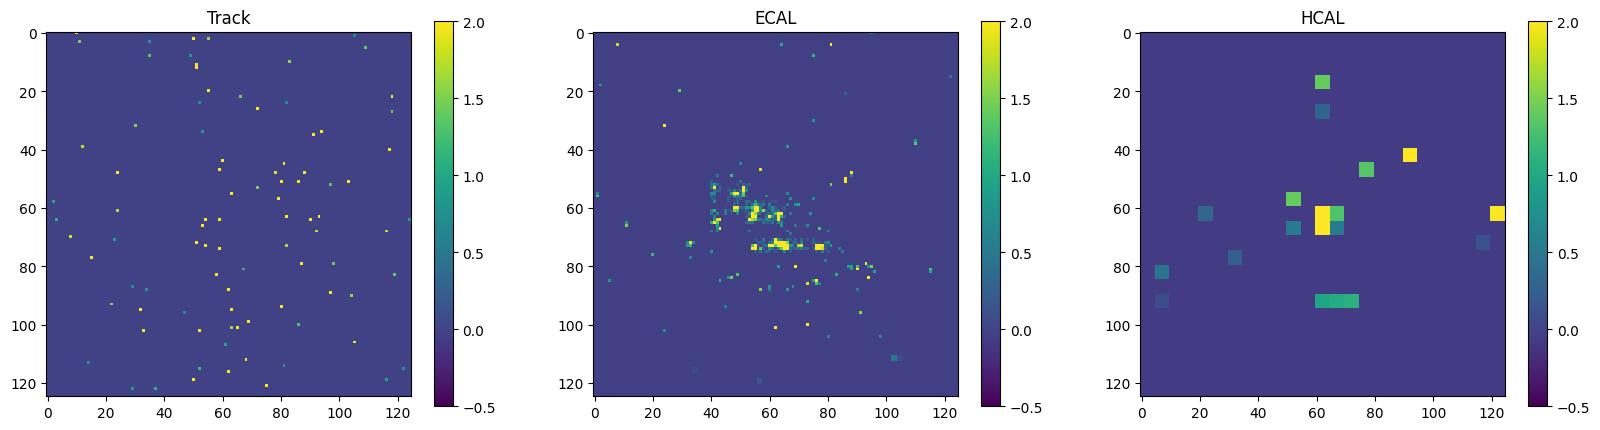

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

im1 = axs[0].imshow(normalized_track[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[0].set_title('Track')

im2 = axs[1].imshow(normalized_ecal[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[1].set_title('ECAL')

im3 = axs[2].imshow(normalized_hcal[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[2].set_title('HCAL')

# Add colorbars
fig.colorbar(im1, ax=axs[0], shrink=0.25)
fig.colorbar(im2, ax=axs[1], shrink=0.25)
fig.colorbar(im3, ax=axs[2], shrink=0.25)

plt.show()

In [26]:
X_jets[:,:,:,0] = normalized_track
X_jets[:,:,:,1] = normalized_ecal
X_jets[:,:,:,2] = normalized_hcal

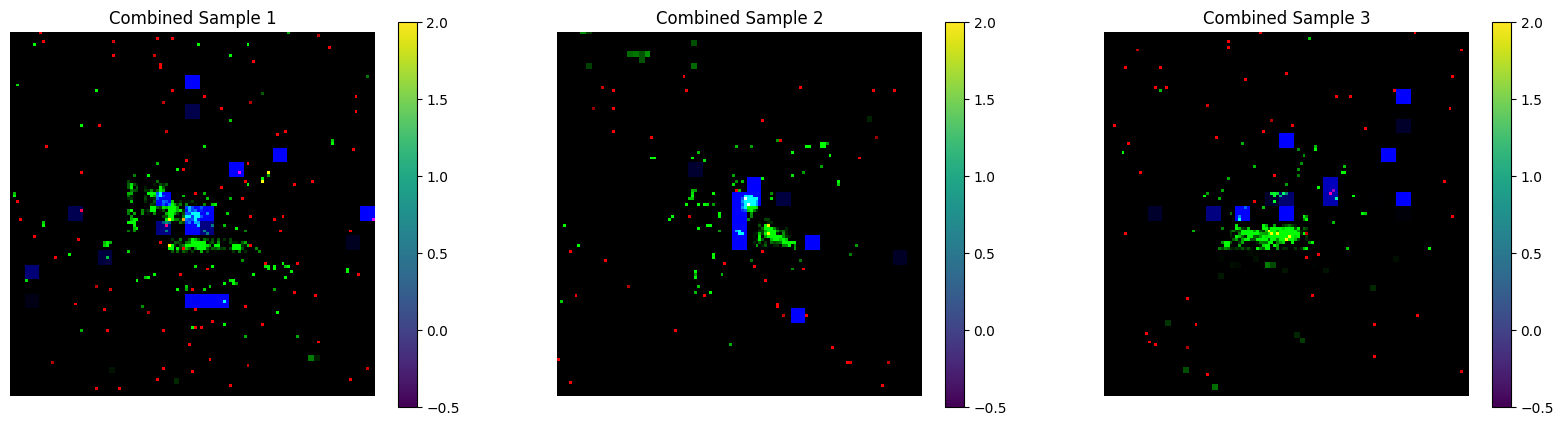

In [27]:
# Select number of images to display
num_images = 3

# Display original images from X_jets
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 20))
for i in range(3):
    temp = axes[i].imshow(X_jets[i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title('Combined Sample {}'.format(i+1))
    fig.colorbar(temp, ax=axes[i], shrink=0.25)
        

# Forward process

In [113]:
# def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
def linear_beta_schedule(timesteps, start=0.00000001, end=0.000002):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [3]:
# import torch
# from torch.utils.data import Dataset
# import h5py
# from torchvision import transforms

# class CustomDataset(Dataset):
#     def __init__(self, data_path, transform=None):
#         self.data_path = data_path
#         self.transform = transform
        
#         with h5py.File(self.data_path, 'r') as f:
#             self.images = f['X_jets'][:6400]
            
#     def __len__(self):
#         return len(self.images)
    
#     def __getitem__(self, idx):
#         batch = self.images[idx : idx+BATCH_SIZE]
#         if self.transform:
#             batch = [self.transform(image) for image in batch]
#         return torch.stack(batch)

In [57]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import h5py
from torchvision import transforms

with h5py.File("/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5", 'r') as f:
    X_jets = f['X_jets'][:6400]

mean_track = np.mean(X_jets[:,:,:,0])
std_track = np.std(X_jets[:,:,:,0])
normalized_track = (X_jets[:,:,:,0] - mean_track) / std_track

mean_ecal = np.mean(X_jets[:,:,:,1])
std_ecal = np.std(X_jets[:,:,:,1])
normalized_ecal = (X_jets[:,:,:,1] - mean_ecal) / std_ecal

mean_hcal = np.mean(X_jets[:,:,:,2])
std_hcal = np.std(X_jets[:,:,:,2])
normalized_hcal = (X_jets[:,:,:,2] - mean_hcal) / std_hcal

# X_jets[:,:,:,0] = normalized_track
# X_jets[:,:,:,1] = normalized_ecal
# X_jets[:,:,:,2] = normalized_hcal

class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        
        # with h5py.File(self.data_path, 'r') as f:
        #     X_jets = f['X_jets'][:6400]

        self.images = X_jets
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [69]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 125
BATCH_SIZE = 128


def minmax_norm(img):
    min_val = np.min(img)
    max_val = np.max(img)
    img = ((img - min_val) / (max_val - min_val))  #* 255  # Multiplication by 255 needed if later transformation conversion to PIL image required float32 to be converted to uint8
    
    return img #.astype(np.uint8)

data_transforms = transforms.Compose([
    transforms.Lambda(minmax_norm),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

data = CustomDataset(data_path='/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5', transform=data_transforms)

# dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)  #drop_last drops the batch with smaller size 

# Split the dataset into training and testing sets
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])

# train_dataset = X_jets[:4000]
# test_dataset =  X_jets[4000:6400]

# Create separate DataLoader objects for the training and testing sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


In [14]:
item = next(iter(dataloader))[0]
print(item.shape)
print(type(item))
print(type(dataloader))

NameError: ignored

In [ ]:
for batch_idx, inputs in enumerate(train_loader):
    print(f"Batch {batch_idx}, inputs shape: {inputs.shape}")

for batch_idx, inputs in enumerate(test_loader):
    print(f"Batch {batch_idx}, inputs shape: {inputs.shape}")


In [5]:
item = next(iter(train_loader))[0]
print(item.shape)
print(type(item))
print(type(train_loader))

torch.Size([3, 125, 125])
<class 'torch.Tensor'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [6]:
print(item)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])


In [7]:
print(np.unique(item.numpy()))

[-1.         -0.9997898  -0.99977046 -0.9997564  -0.9997256  -0.99971527
 -0.99954444 -0.9994744  -0.99939436 -0.99939406 -0.9993222  -0.99921846
 -0.9991981  -0.99919754 -0.9991464  -0.99901783 -0.9988622  -0.99883133
 -0.99869776 -0.99867076 -0.9985841  -0.9984642  -0.99832183 -0.9982947
 -0.9982034  -0.99819505 -0.99808866 -0.9980492  -0.99799895 -0.9979898
 -0.99782354 -0.9977779  -0.9976301  -0.99751204 -0.99744016 -0.99730223
 -0.99719316 -0.99713576 -0.99711055 -0.9969968  -0.99693215 -0.9968983
 -0.99679303 -0.99665695 -0.9966331  -0.99658734 -0.99638516 -0.9963169
 -0.9962351  -0.9960121  -0.99547446 -0.99544764 -0.995235   -0.99509555
 -0.9950343  -0.9949755  -0.9948366  -0.99471253 -0.9945864  -0.99428153
 -0.99409306 -0.9940266  -0.99395645 -0.9938656  -0.99380624 -0.9937723
 -0.99376774 -0.9937252  -0.99370134 -0.9935681  -0.993519   -0.9935155
 -0.99348825 -0.9933086  -0.99308234 -0.9929282  -0.9928569  -0.9928337
 -0.9928047  -0.9927932  -0.9926036  -0.9925976  -0.992543

In [56]:
# Normalize Track, ECAL, HCAL data using mean and standard deviation
mean_track = np.mean(X_jets[:,:,:,0])
std_track = np.std(X_jets[:,:,:,0])

mean_ecal = np.mean(X_jets[:,:,:,1])
std_ecal = np.std(X_jets[:,:,:,1])

mean_hcal = np.mean(X_jets[:,:,:,2])
std_hcal = np.std(X_jets[:,:,:,2])

mean = [mean_track, mean_ecal, mean_hcal] 
std = [std_track, std_ecal, std_hcal]

In [104]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Normalize(mean=mean, std=std),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda im: np.array(im)), # convert to NumPy array
    ])
    
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 

    # image = reverse_transforms(combined)
    image = reverse_transforms(image)

    # Combine Track, ECAL, and HCAL channels
    combined = torch.sum(torch.from_numpy(image), dim=-1, keepdim=True)
    
    # print(image.shape)
    # print(type(image))
    # print(image)

    plt.imshow(image, cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    plt.imshow(combined, cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')


<ipython-input-116-16147eac72d0>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, math.ceil((idx/stepsize)) + 1)


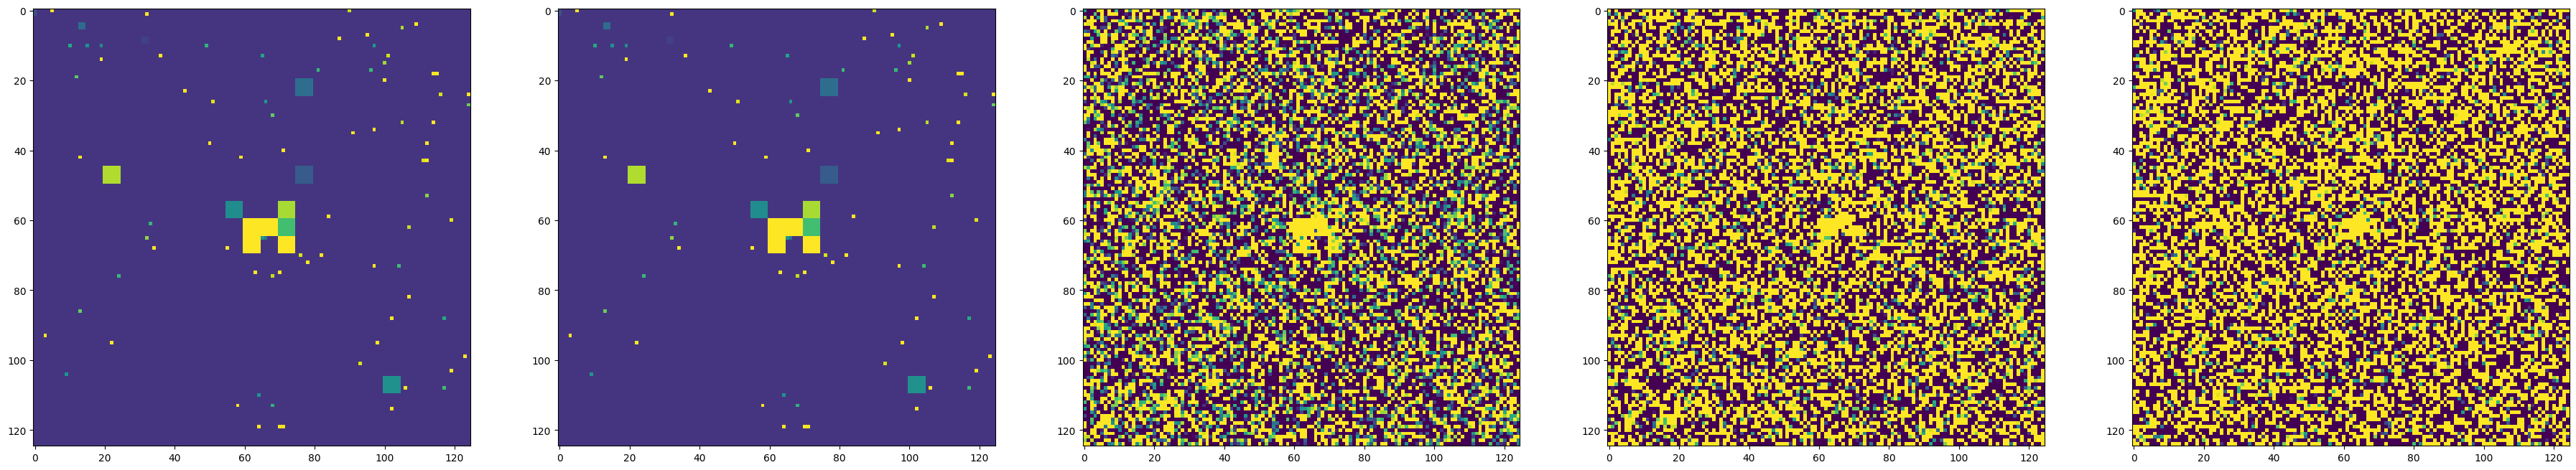

In [116]:
plt.figure(figsize=(55,55))
plt.axis('off')
num_images = 5
stepsize = int(T/num_images)

# Simulate forward diffusion
image = next(iter(train_loader))[0]

# print(image.type)
show_tensor_image(image)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, math.ceil((idx/stepsize)) + 1)
    show_tensor_image(image)
    image, noise = forward_diffusion_sample(image, t)
    # show_tensor_image(image)

## Training 

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        if step == 0:
            print(f"Epoch {epoch} | step {step:03d} Training Loss: {loss.item()} ")
            
            # Evaluate the model on the test set after each epoch
            test_loss = 0
            with torch.no_grad():
                for test_step, test_batch in enumerate(test_loader):
                    test_t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
                    test_loss += get_loss(model, test_batch[0], test_t).item()
                test_loss /= (test_step + 1)
            print(f"Epoch {epoch} | step {step:03d} Test Loss: {test_loss} ")
            
            sample_plot_image()


# Discussion

* As dataset images contain physical data rather than RGB values seen in classical images, data preprocessing steps need to be carefully chosen to ensure that the physical properties of the data are not lost during the conversion process. For example, in our case, we had to be careful in scaling the pixel values to avoid losing the relative important features of the image.

*  The choice of beta schedule is crucial in the success of training the diffusion model. In our case, we started with a linear beta schedule and tried to adjust the start and end values to balance between underfitting and overfitting. However, the resulting images were not of high quality.

*   There is still a need for further exploration and optimization to achieve high-quality diffusion models for physical data such as quark/gluon images. More research is required to investigate different diffusion schedules, data pre-processing techniques, and other model architectures that can better capture the underlying features of the data.

*  Another challenge was in visualizing the intermediate images generated at each step of the diffusion process. Normalization techniques had to be carefully choosen to obtain clear and informative visualizations.

The choice of beta schedule is crucial in the success of training the diffusion model. In our case, we started with a linear beta schedule and tried to adjust the start and end values to balance between underfitting and overfitting. However, the resulting images were not of high quality.


Another challenge was in visualizing the intermediate images generated at each step of the diffusion process. We had to carefully choose the plotting function and adjust the image size and axis settings to obtain clear and informative visualizations.